In [1]:
import numpy as np

In [2]:
from sklearn.datasets import fetch_openml

# Establece el parser en 'auto' para evitar la advertencia
mnist = fetch_openml('mnist_784', version=1, parser='auto')

# Ahora puedes usar el conjunto de datos como de costumbre


In [3]:
X, y = mnist["data"], mnist["target"]

In [4]:
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

C:\Users\erdav\anaconda3\lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


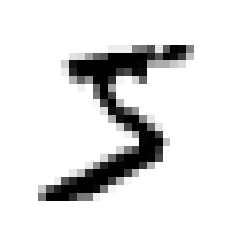

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

# Cargar el conjunto de datos MNIST
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist.data, mnist.target

# Convertir los datos a un DataFrame de Pandas (opcional)
import pandas as pd
X = pd.DataFrame(X)

# Ahora puedes acceder a los datos y mostrar una imagen, por ejemplo, la primera imagen:
some_digit = X.iloc[0]  # Accede a la primera fila de X
some_digit_image = some_digit.values.reshape(28, 28)  # Convierte la fila en una imagen 28x28
plt.imshow(some_digit_image, cmap=mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()


In [7]:
y[0]

'5'

In [8]:
y = y.astype(np.uint8)

Dividir datos en entrenamiento y prueba

In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Entrenando un clasificador binario

Identicar un solo digito, si es 5 o no es 5

In [12]:
y_train_5 = (y_train == 5) # verdadero si es 5, falso los demas digitos
y_test_5 = (y_test == 5)

Elegimnos un clasificador. Un buen lugar para empezar es con el Stochastic Gradient Descent (SGD)
Este clasificador es capaz de manejar grandes conjuntos de datos eficientemente.
El SGD puede lidiar con observaciones de entrenamiento independientemente, uno a la vez.
Los usaremos en el conjunto de entrenamiento entero

In [15]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

Ahora podemos usarlos para detectar imagenes con el numero 5

In [16]:
sgd_clf.predict([some_digit])

C:\Users\erdav\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

NotaL: Mezclar puede ser mala idea en algunos contextos, por ejemplo si usan series de tienpo
Arriba se hizo shuffling

## Medidas de Performance

Existen varias medidas de performance

### Medir presicion usando cross-validation

Una buena forma de evaluar un modelo es usando cross-validation.

Usaremos cross_val_score() para evaluar el modelo de SGDClassifier

K-folds significa dividir el modelo de entrenamiento en K-folds (en este caso 3)

In [20]:
>>> from sklearn.model_selection import cross_val_score
>>> cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Cerca del 95% de presicion (proporcion de predcciones correctas) en todos los folds de cross validation

Usaremos un clasificador para comparar, este compara cada imagen en la clase de 
"no es 5"

In [22]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [23]:
>>> never_5_clf = Never5Classifier()
>>> cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

Tiene un 90% de presicion ya que cerca del 10% de las imagenes son 5, asi que si siempre se adivina una imagen que no es un 5, tendras presicion de un 90%.

Esto demuestra porque la presicion es generalmente no preferida como medidor de performance para clasificadores, especialmente cuando son datasets sesgados

## Matriz de confusion

Es un mejor evaluador de performance de un clasificador.
La idea general es contar el numero de veces que las observaciones son clasificadas como clase A son clasificadas como clase B. por ejemplo, para saber el numero de veces que un clasificador confunde imagenes del 5 con el 3, observaras en l quinta fila y la tercer columna en la matriz de confusion

Para calcular la matriz de confusion, primero se debe tener un set de predicciones, para que puedan ser comparados con los objetivios actuales.
Se podrian hacer predicciones con el conjunto de prueba, pero no los tocaremos por ahora. (test set se usa de preferencia al final del proyecto)

En su lugar usaremos la funcion cross_val_predict()

In [24]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Al igual que la función cross_val_score(), cross_val_predict() realiza K-fold
cross validation, pero en lugar de devolver las puntuaciones de evaluación, devuelve las predicciones realizadas en cada pliegue de la prueba. Esto significa que obtienes una predicción limpia para cada
instancia en el conjunto de entrenamiento ("limpio", lo que significa que la predicción la realiza un modelo
que nunca vio los datos durante el entrenamiento)

Ahora estamos listos para hacer una matriz de confusion

In [25]:
>>> from sklearn.metrics import confusion_matrix
>>> confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

Cada fila en una matriz de confusión representa una clase real, mientras que cada columna representa
envía una clase prevista. La primera fila de esta matriz considera imágenes que no son 5 (las imágenes negativas): 53892 de ellos fueron clasificados correctamente como no 5 (se les llama verdaderos
negativos), mientras que los 687 restantes fueron clasificados erróneamente como 5 (falsos positivos).
La segunda fila considera las imágenes de 5 (la clase positiva): 1891 estaban equivocadas
clasificados como no 5 (falsos negativos), mientras que los 3530 restantes se clasificaron correctamente.
clasificados como 5 (verdaderos positivos). Un clasificador perfecto sólo tendría verdaderos positivos y verdaderos.
negativos, por lo que su matriz de confusión tendría valores distintos de cero sólo en su diagonal principal.
final (de arriba a la izquierda a abajo a la derecha):

In [27]:
>>> y_train_perfect_predictions = y_train_5 # pretendemnos que alcanzamos la perfeccion
>>> confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

## Precision y recuperacion

Calcular metricas de clasificacion

In [29]:
>>> from sklearn.metrics import precision_score, recall_score
>>> precision_score(y_train_5, y_train_pred) # == 3530 / (3530 + 687)

0.8370879772350012

In [30]:
recall_score(y_train_5, y_train_pred) # == 3530 / (3530 + 1891)

0.6511713705958311

Ahora su detector de 5 no se ve tan brillante como cuando observó su precisión.
Cuando afirma que una imagen representa un 5, es correcto sólo el 83,7% de las veces. Más-
Además, sólo detecta el 65,1% de los 5